## Module 2: CZ-Gate Fidelity Optimization - Post Processing

This notebook analyzes the results from the multi-process optimization:
- The results are obtained via running [module2_CZ_gate_fidelity_optimization_multi_process.py](module2_CZ_gate_fidelity_optimization_multi_process.py)
- Load and visualize optimization convergence for individual B values
- Compare optimal parameters across different Rydberg blockade strengths
- Generate plots using `plotting_helpers.py`

In [ ]:
# Import required libraries
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# Import custom modules
from optimization_utils import OptimizationMonitor
from plotting_helpers import plot_fidelity_vs_parameter, plot_optimization_convergence, plt_config
from utils import *

### 1. Load Summary Data

In [7]:
# Set data directory
# data_dir = Path('optimization_results/20260107_233700_CZ_gate_ARP_RydbergB')
data_dir = Path('save_data/20260108_130551_CZ_gate_ARP_RydbergB')
df = load_optimization_summary(data_dir, verbose=True)

✅ Loaded summary data: 12 optimization results

    Rydberg_B_MHz  fidelity    T_gate  tau_ratio  amp_Omega_r  amp_Delta_r
0             500  0.998472  1.235824      0.175    44.066808    62.925299
1             600  0.998068  1.250000      0.175    51.715060    91.497020
2             700  0.998322  1.218656      0.175    53.313573    93.966030
3             800  0.998105  1.249600      0.175    58.957607   120.291180
4             900  0.998320  1.244133      0.175    60.307793   121.608321
5            1000  0.998484  1.247749      0.175    60.368770   119.350787
6            1250  0.998748  1.240413      0.175    61.893300   119.657980
7            1500  0.998857  1.039095      0.175    74.374169   148.714592
8            1750  0.998997  1.153475      0.175    69.842311   135.199803
9            2000  0.999072  0.949034      0.175    82.519435   161.664927
10           2500  0.999207  0.952383      0.175    84.666264   160.285437
11           3000  0.999283  0.942311      0.175    

### 2. Plot Fidelity vs Rydberg Blockade Strength

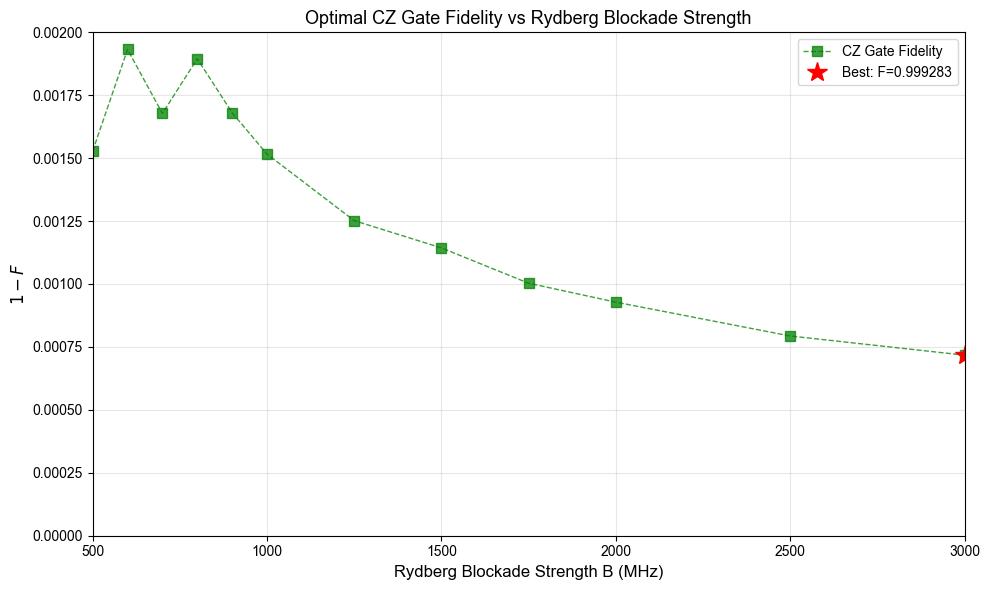


🏆 Best Fidelity Result:
  B = 3000 MHz
  Fidelity = 0.999283
  Infidelity = 7.17e-04


In [9]:
# Apply plotting configuration
plt.rcParams.update(plt_config)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot fidelity vs B using plotting_helpers function
plot_fidelity_vs_parameter(
    ax=ax,
    param_list=df['Rydberg_B_MHz'].values,
    fidelity_list=[df['fidelity'].values],
    legend_list=['CZ Gate Fidelity'],
    title='Optimal CZ Gate Fidelity vs Rydberg Blockade Strength',
    xlabel='Rydberg Blockade Strength B (MHz)',
    ylabel='Fidelity',
    use_infidelity=True,
    log_scale=False,
    ylim=[0, 0.002],
    grid_alpha=0.3,
    show_legend=True
)

# Mark the best fidelity point
best_idx = df['fidelity'].idxmax()
ax.plot(df.loc[best_idx, 'Rydberg_B_MHz'], 1 - df.loc[best_idx, 'fidelity'], 
        'r*', markersize=15, label=f"Best: F={df.loc[best_idx, 'fidelity']:.6f}")
ax.legend()

plt.tight_layout()
plt.show()

# Print best result
print(f"\n🏆 Best Fidelity Result:")
print(f"  B = {df.loc[best_idx, 'Rydberg_B_MHz']:.0f} MHz")
print(f"  Fidelity = {df.loc[best_idx, 'fidelity']:.6f}")
print(f"  Infidelity = {1 - df.loc[best_idx, 'fidelity']:.2e}")

### 3. Plot Optimized Parameters vs B

In [10]:
# Parameter bounds
bounds = {
        'T_gate': (0.15, 1.25),
        'tau_ratio': (0.175, 0.175), # Fixed tau_ratio for ARP ( why? )
        'amp_Omega_r': (5*2*np.pi, 20*2*np.pi),
        'amp_Delta_r': (10*2*np.pi, 35*2*np.pi)
    }

d:\Notion_Projects\Notion_Open_Quantum_System\qubits_simulation_codes\Neutral_Atom_Qubit_Simulations\plotting_helpers.py:951: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ylim)


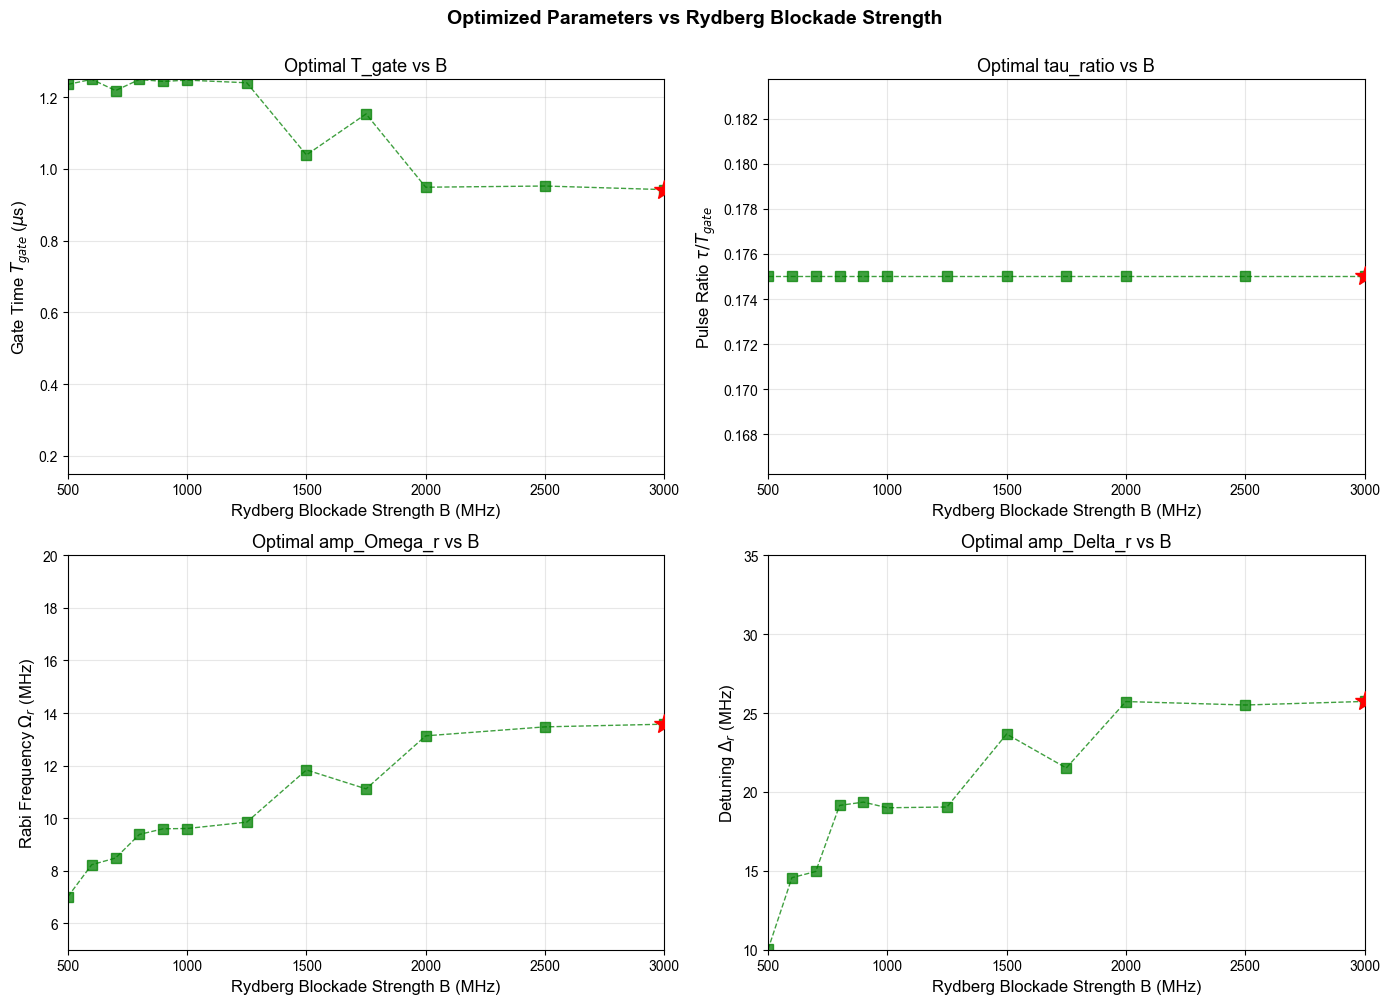

In [11]:
from plotting_helpers import plot_parameter_vs_parameter

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Parameter information: (column_name, ylabel, need_conversion_to_MHz)
param_info = [
    ('T_gate', r'Gate Time $T_{gate}$ ($\mu$s)', False, axes[0, 0]),
    ('tau_ratio', r'Pulse Ratio $\tau / T_{gate}$', False, axes[0, 1]),
    ('amp_Omega_r', r'Rabi Frequency $\Omega_r$ (MHz)', True, axes[1, 0]),
    ('amp_Delta_r', r'Detuning $\Delta_r$ (MHz)', True, axes[1, 1])
]

for param_name, ylabel, convert_to_MHz, ax in param_info:
    # Convert to appropriate units
    if convert_to_MHz:
        # Convert from rad/μs to MHz
        param_values = df[param_name].values / (2 * np.pi)
        best_val = df.loc[best_idx, param_name] / (2 * np.pi)
    else:
        param_values = df[param_name].values
        best_val = df.loc[best_idx, param_name]
    
    # Use plot_parameter_vs_parameter function
    plot_parameter_vs_parameter(
        ax=ax,
        x_param_list=df['Rydberg_B_MHz'].values,
        y_param_list=[param_values],
        legend_list=[param_name],
        title=f'Optimal {param_name} vs B',
        xlabel='Rydberg Blockade Strength B (MHz)',
        ylabel=ylabel,
        show_legend=False,
        grid_alpha=0.3,
        ylim = bounds[param_name] if not convert_to_MHz else (bounds[param_name][0]/(2*np.pi), bounds[param_name][1]/(2*np.pi))
    )
    
    # Mark best fidelity point
    ax.plot(df.loc[best_idx, 'Rydberg_B_MHz'], best_val, 
            'r*', markersize=15, label='Best Fidelity', zorder=5)

plt.suptitle('Optimized Parameters vs Rydberg Blockade Strength', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 4. Load and Analyze Individual Optimization Monitors

Load the optimization monitor for a specific B value to examine convergence details.

In [11]:
# List available monitor files (now in subdirectories)
# Find all B*MHz subdirectories
b_dirs = sorted(data_dir.glob('B*MHz'))

if b_dirs:
    print(f"📂 Found {len(b_dirs)} B directories:\n")
    monitor_files = []
    for b_dir in b_dirs:
        # Find monitor files in each directory
        monitors_in_dir = list(b_dir.glob('monitor_*.pkl'))
        monitor_files.extend(monitors_in_dir)
        print(f"  - {b_dir.name}: {len(monitors_in_dir)} monitor files")
    
    print(f"\n📄 Total monitor files: {len(monitor_files)}")
else:
    # Fallback: try old structure (monitor files directly in data_dir)
    monitor_files = sorted(data_dir.glob('monitor_B*MHz.pkl'))
    print(f"📂 Found {len(monitor_files)} monitor files (old structure):\n")
    for file in monitor_files:
        print(f"  - {file.name}")

📂 Found 12 B directories:

  - B1000MHz: 1 monitor files
  - B1250MHz: 1 monitor files
  - B1500MHz: 1 monitor files
  - B1750MHz: 1 monitor files
  - B2000MHz: 1 monitor files
  - B2500MHz: 1 monitor files
  - B3000MHz: 1 monitor files
  - B500MHz: 1 monitor files
  - B600MHz: 1 monitor files
  - B700MHz: 1 monitor files
  - B800MHz: 1 monitor files
  - B900MHz: 1 monitor files

📄 Total monitor files: 12


In [12]:
# Select a B value to analyze (e.g., the one with best fidelity)
B_to_analyze = int(df.loc[best_idx, 'Rydberg_B_MHz'])

# Try to find monitor file in new structure (B*MHz subdirectory)
monitor_path = data_dir / f'B{B_to_analyze}MHz' / 'monitor_init0.pkl'

# Fallback to old structure if not found
if not monitor_path.exists():
    monitor_path = data_dir / f'monitor_B{B_to_analyze}MHz.pkl'

if monitor_path.exists():
    # Load monitor (without objective function for inspection)
    with open(monitor_path, 'rb') as f:
        monitor_data = pickle.load(f)
    
    print(f"✅ Loaded monitor for B = {B_to_analyze} MHz")
    print(f"   From: {monitor_path.relative_to(data_dir)}\n")
    
    # Extract best result
    history = monitor_data.history
    param_names = monitor_data.param_names
    
    # Find best iteration
    best_iter = np.argmax(history['fidelity'])
    
    print(f"📊 Optimization Summary:")
    print(f"  Total iterations: {len(history['iteration'])}")
    print(f"  Best iteration: {history['iteration'][best_iter]}")
    print(f"  Best fidelity: {history['fidelity'][best_iter]:.6f}")
    print(f"  Best infidelity: {history['infidelity'][best_iter]:.2e}")
    print(f"\n  Best parameters:")
    for name in param_names:
        if 'amp' in name:
            print(f"    {name}: {history[name][best_iter]/(2*np.pi):.4f} MHz")
        else:
            print(f"    {name}: {history[name][best_iter]:.4f}")
else:
    print(f"❌ Monitor file not found: {monitor_path}")
    print(f"   Tried: B{B_to_analyze}MHz/monitor_init0.pkl")
    print(f"   Also tried: monitor_B{B_to_analyze}MHz.pkl")

✅ Loaded monitor for B = 3000 MHz
   From: B3000MHz\monitor_init0.pkl

📊 Optimization Summary:
  Total iterations: 71
  Best iteration: 71
  Best fidelity: 0.999186
  Best infidelity: 8.14e-04

  Best parameters:
    T_gate: 1.0313
    tau_ratio: 0.1750
    amp_Omega_r: 13.7893 MHz
    amp_Delta_r: 29.0871 MHz


### 5. Plot Optimization Convergence

Use `plotting_helpers.plot_optimization_convergence()` to visualize how the optimization progressed.

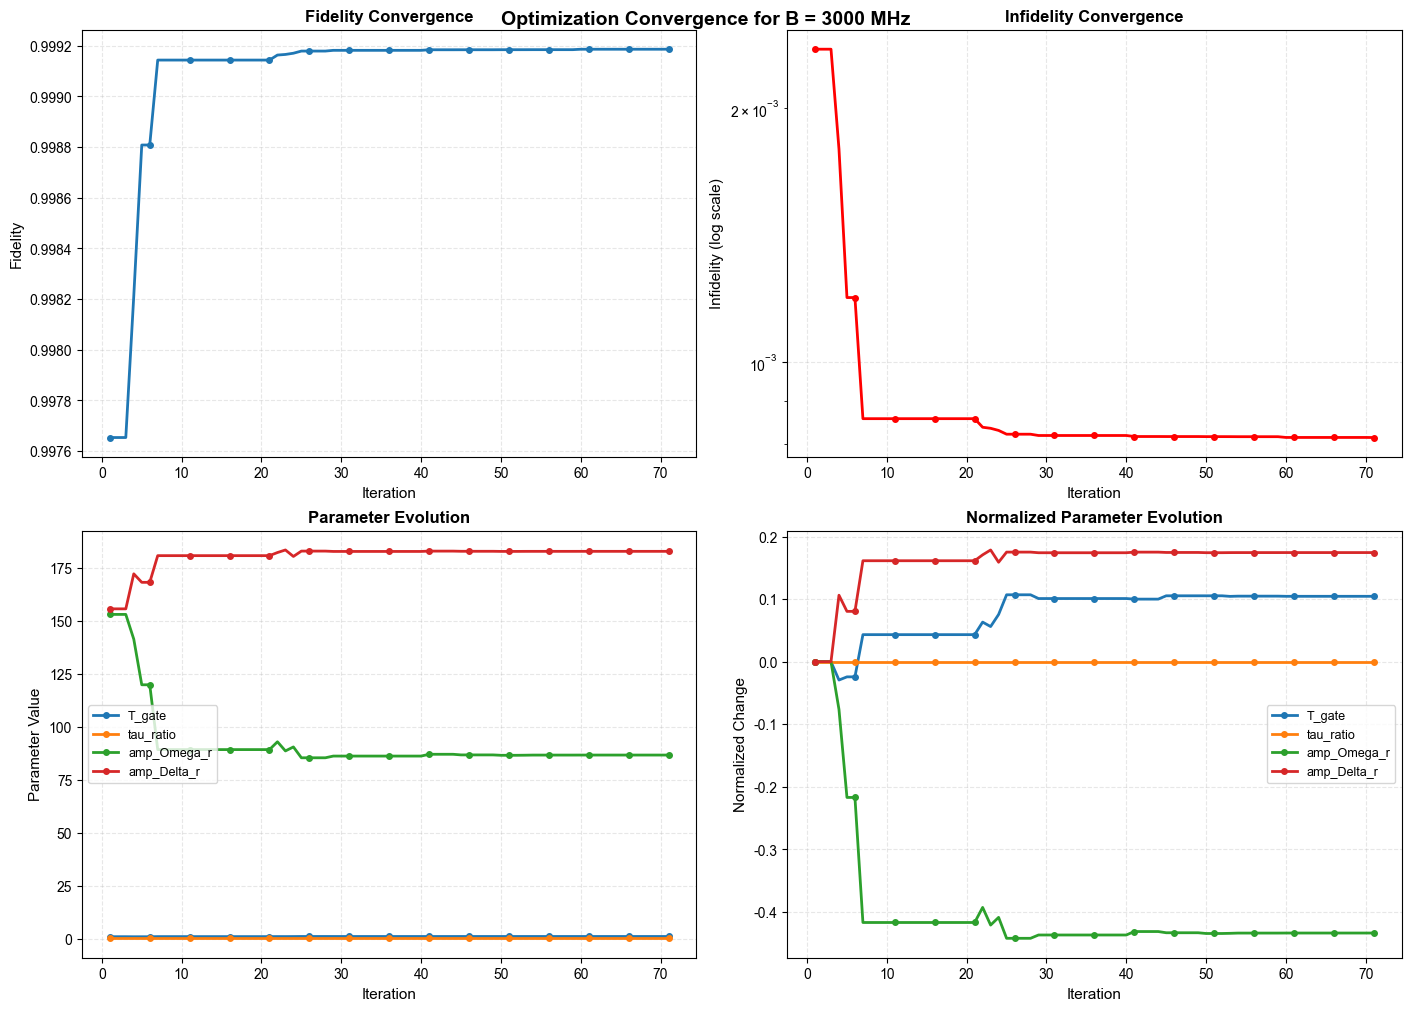

In [13]:
# Plot convergence using plotting_helpers function
fig, axes = plot_optimization_convergence(history, param_names, figsize=(14, 10))

# Add title with B value
fig.suptitle(f'Optimization Convergence for B = {B_to_analyze} MHz', 
             fontsize=14, fontweight='bold', y=0.995)

plt.show()